<a href="https://colab.research.google.com/github/NikolaevMikhailRoma/Other-Projects/blob/main/AB_test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from statsmodels.stats.weightstats import *

Вводная: необходимо рассмотреть возможность АБ тестирования для проверки двух вариантов (10 и 90) используемых в онлайн магазине. Даны колонки с  **date** - датой, **Variant** - вариантом, **cnt(addToCart)** кол-во добавлений в корзину, **sum(addToCartItems)** - сумма товаров в корзине. Для полного анализа метрик маловато, работаем с тем что есть.

# 1. Бегло посмотрим на данные

In [13]:
url = 'https://raw.githubusercontent.com/NikolaevMikhailRoma/Other-Projects/main/%D0%AE%D0%B2%D0%B5%D0%BB%D0%B8%D1%80%D0%BD%D1%8B%D0%B9%20%D0%BC%D0%B0%D0%B3%D0%B0%D0%B7%D0%B8%D0%BD%2C%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5%20-%20%D0%9B%D0%B8%D1%81%D1%821.csv'
df = pd.read_csv(url)
df.head()

,date,Variant,cnt(addToCart),sum(addToCartItems)
0,2019-09-01,90,56,110247
1,2019-09-01,10,52,163098
2,2019-09-02,10,59,93317
3,2019-09-02,90,56,26457
4,2019-09-03,90,54,56418


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date                 50 non-null     object
 1   Variant              50 non-null     int64 
 2   cnt(addToCart)       50 non-null     int64 
 3   sum(addToCartItems)  50 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.7+ KB


In [15]:
# оформим данные для просто обращения и добавим свою метрику AvePrice
df.rename(columns={"Variant": "var", "cnt(addToCart)": "cnt", 'sum(addToCartItems)' : 'sum'}, inplace = True)
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df['AvePrice'] = df['sum'] / df['cnt']
df['var'] = df['var'].apply(lambda x: str('B') if x==90 else str('A'))

df.head()

,date,var,cnt,sum,AvePrice
0,2019-09-01,B,56,110247,1968.696429
1,2019-09-01,A,52,163098,3136.500000
2,2019-09-02,A,59,93317,1581.644068
3,2019-09-02,B,56,26457,472.446429
4,2019-09-03,B,54,56418,1044.777778


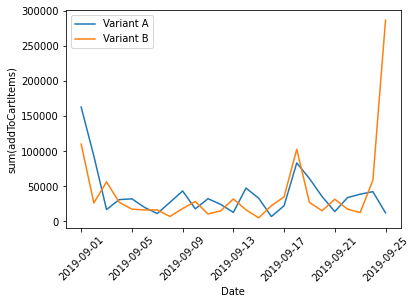

In [16]:
plt.plot('date', 'sum', data = df[df['var'] =='A'], label='Variant A')
plt.plot('date', 'sum', data = df[df['var'] =='B'], label='Variant B')

plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("sum(addToCartItems)")
plt.legend()
plt.show()

При обработке данных стоит обратить внимание на выбросы (очевидно - конец месяца)

Вариант А:  958822
Вариант B:  1015053


<Figure size 800x640 with 0 Axes>

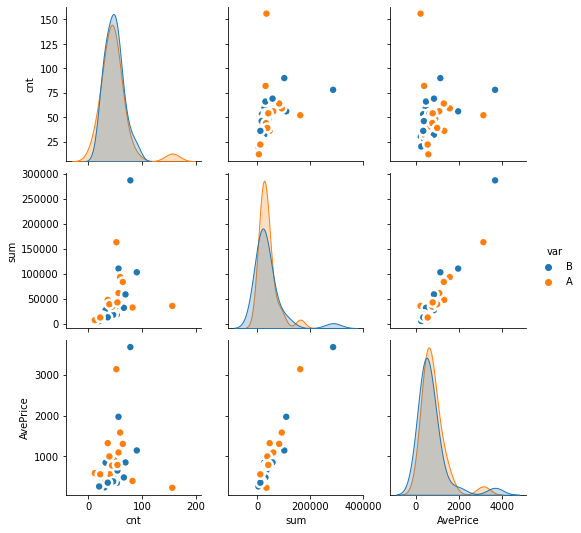

In [17]:
# цель предприятия - максимизация прибыли

print('Вариант А: ', df['sum'][df['var'] =='A'].sum())
print('Вариант B: ', df['sum'][df['var'] =='B'].sum())

plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(df, kind="scatter", hue="var", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

Сумма по корзине: Вариант А:  946554
Сумма по корзине: Вариант B:  728097


<Figure size 800x640 with 0 Axes>

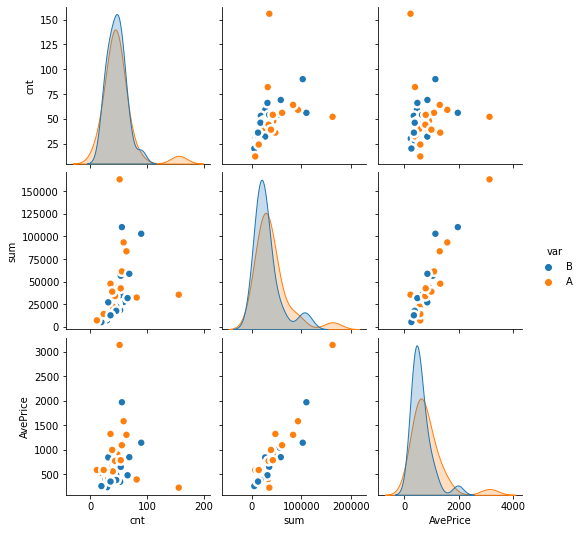

In [18]:
# профильтруем данные по квантилям и посмотрим на результат
# df2 = df[
#          (df['sum'] > df['sum'].quantile(0.05))&
#          (df['sum'] < df['sum'].quantile(0.95))]

# или корректнее исключить дату с аномальным значением в конце месяца, тем более что очевидных особенных событий (сентябрь) в нем не присутствует
df2 = df[0:-2]

# цель предприятия - максимизация прибыли
print('Сумма по корзине: Вариант А: ', df2['sum'][df2['var'] =='A'].sum())
print('Сумма по корзине: Вариант B: ', df2['sum'][df2['var'] =='B'].sum())

plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(df2, kind="scatter", hue="var", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

Выводы неочевидны, после фильтра результаты вариантов меняются на противоположные и присутствуют отдельные выбросы.
На первый взгляд достаточно мало данных для подведения точной статистики, попробуем применить АБ-тест и бустреп. Сформируем нулевую гипотезу - разницы в вариантах нет (что мы должны определить по p-value) и применим альтернативные гипотезы если первая не подтвердиться.

# 2. Расчитаем p_value

Text(0, 0.5, 'Diff В-А (now pers)')

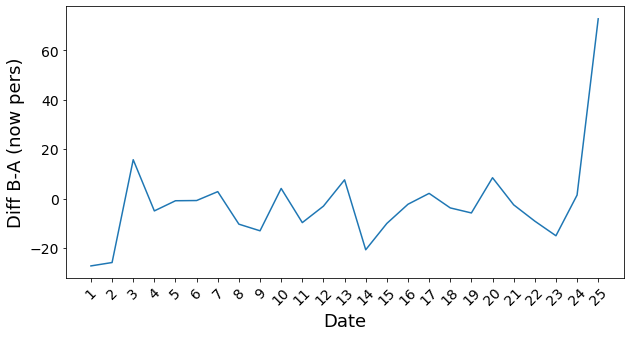

In [19]:
# Построим график с разницей значений!, для дальнейшего анализа исключим последнюю дату

AvePriceA = np.array(df['AvePrice'][df['var']=='A'])
AvePriceB = np.array(df['AvePrice'][df['var']=='B'])
diff = AvePriceB-AvePriceA

diff = diff/(max(diff)- min(diff)) #activation if you want to get persents

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(diff*100)
myFmt = pd.to_datetime(df['date'].unique(),format = '%Y-%m-%d').day
# print(myFmt)
# ax.xaxis(myFmt)
plt.xticks(list(range(len(myFmt))), myFmt)
plt.xticks(fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=14)
plt.xlabel("Date",fontsize=18)
plt.ylabel("Diff В-А (now pers)",fontsize=18)

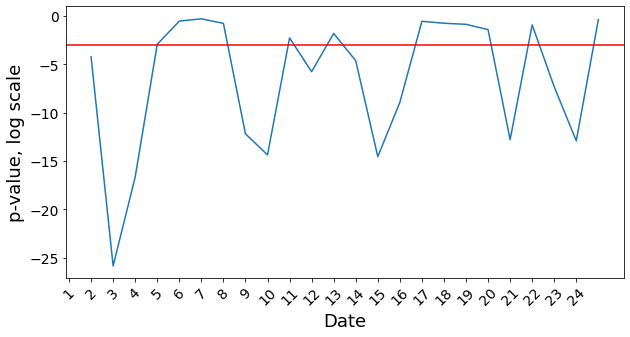

In [20]:
# calculate p_value
# a modified copy of the code, 
df = df[0:-2] # убираем последнюю дату
myFmt = pd.to_datetime(df['date'].unique(),format = '%Y-%m-%d').day 


sumA, sumB = np.array(df['sum'][df['var'] == 'A']), np.array(df['sum'][df['var'] == 'B'])
cntA, cntB = np.array(df['cnt'][df['var'] == 'A']), np.array(df['cnt'][df['var'] == 'B'])

from statsmodels.stats.proportion import proportions_ztest
new_ar=[]

for i in range(len(cntA)): # len of sample
    nobs = np.array([sumA[i], sumB[i]])
    count = np.array([cntA[i], cntB[i]])
    stat, pval = proportions_ztest(count, nobs)
    new_ar.append(pval)

# в четыре часа утра я думаю что это более правильный вариант
# new_ar=[]
# for i in range(len(cntA)): # len of sample
#     nobs = np.array([sum(sumA[0:i]), sum(sumB[0:i])])
#     count = np.array([sum(cntA[0:i]), sum(cntB[0:i])])
#     stat, pval = proportions_ztest(count, nobs)
#     new_ar.append(pval)

p_value = pd.DataFrame(new_ar)
p_value = p_value.rename(columns={0: "p_val"})
p_value['date'] =  myFmt

p_value = p_value.set_index('date')

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(np.log(p_value.p_val))
plt.xticks(list(range(len(myFmt))), myFmt)

plt.xticks(fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=14)
plt.xlabel("Date",fontsize=18)
plt.ylabel("p-value, log scale",fontsize=18)
plt.axhline(np.log(0.05), color='r') # trigger p_value line

Построена логарифмическая шкала и по конечному параметру p_value считается что разницы между вариантами нет. Однако постоянного значения не наблюдается и мы не можем сказать что это применимо для подавляющего большинства массива данных, также размер статистики у нас мал. Для более однозначных выводов воспользуемся бустрепом

# 3. Бутстреп. Значимость средней стоимости заказа

In [21]:
def bootstrap(arr,n=100,N_TRIAL = 1000,func = np.mean): # искуственно создаём новые данные 
    res = []
    n = min(len(arr),n)
    # Инициализируем цикл попыток
    for _ in range(N_TRIAL):
        # Делаем подвыборку размера n
        if len(arr.shape)>1:
            ind = np.random.choice(np.arange(arr.shape[0]), size = (n,))
            subsample = arr.iloc[ind]
        else:
            subsample = np.random.choice(arr, size = (n,))
        # рассчитываем статистику
        stat = func(subsample)
        res.append(stat)
    return res # shape (N_TRIAL,)

def samples(col = 'AvePrice', data = df):
  return (bootstrap(data.query("var=='A'")[col],N_TRIAL = 3000), bootstrap(data.query("var=='B'")[col],N_TRIAL = 3000))

def centered_sample(col = 'AvePrice', data = df):
  buf = []

  dataA = data.query("var=='A'")[col].copy()
  dataB = data.query("var=='B'")[col].copy()
  for i in range(1000):
      a_sample =  dataA.sample(100, replace = "True")
      b_sample =  dataB.sample(100, replace = "True")
      buf.append(np.mean(b_sample)-np.mean(a_sample))
  return buf

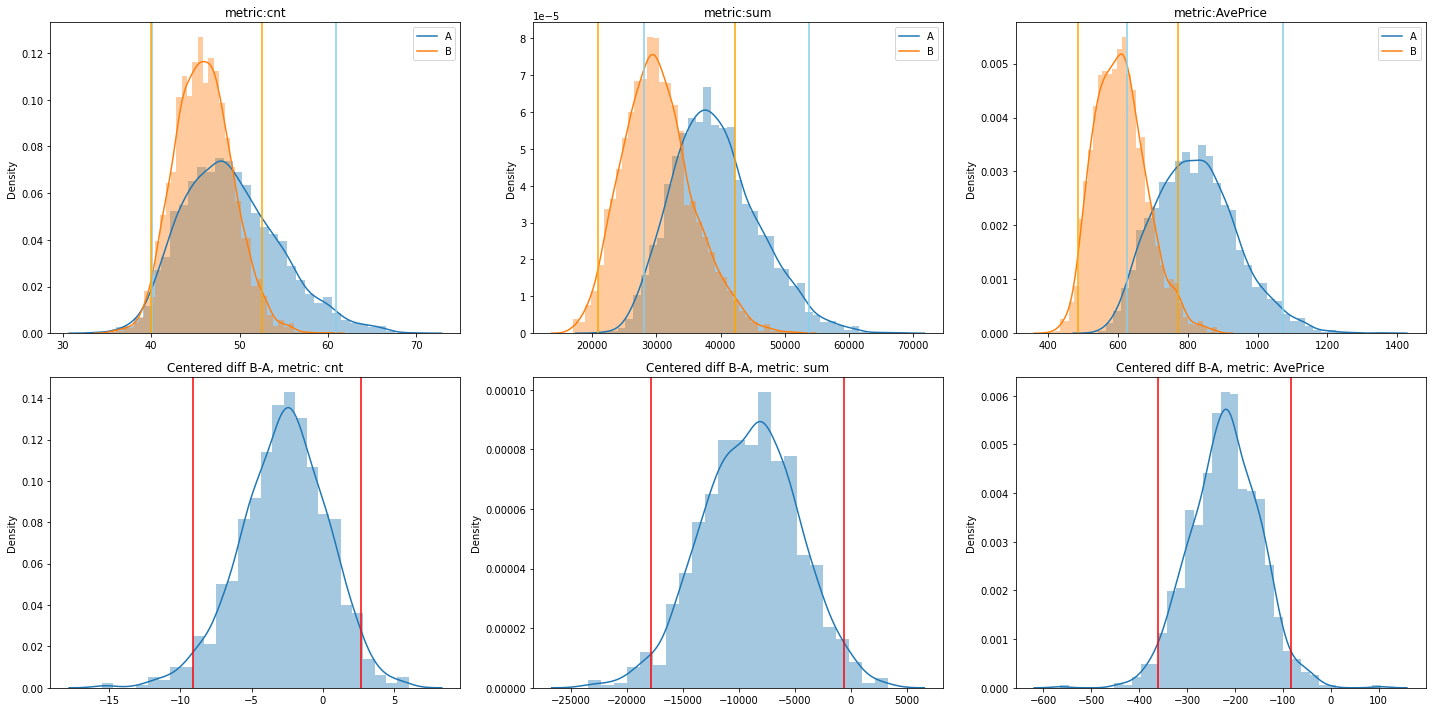

In [22]:
data = df # данные уже отфильтрованны

#### WARNING отключаю предупреждения
import warnings
warnings.filterwarnings("ignore")
####

import seaborn as sns

fig, ax = plt.subplots(2, 3, figsize=(20, 10)) #

ax = ax.ravel()### обращение по индексу 

def plot_bootstrap(data = df, col = 'AvePrice', axes = 0):

    samples_a, samples_b = samples(col = col)

    sns.distplot(samples_a,label = 'A', ax = ax[axes])
    sns.distplot(samples_b, label = 'B', ax = ax[axes])
    ax[axes].legend(['A','B'])
    # выведем доверительные интервалы для наших выборок
    ax[axes].axvline(np.percentile(samples_a,2.5),linestyle = '-',color='skyblue') # 
    ax[axes].axvline(np.percentile(samples_a,97.5),linestyle = '-',color='skyblue')
    ax[axes].axvline(np.percentile(samples_b,2.5),linestyle = '-',color='orange')
    ax[axes].axvline(np.percentile(samples_b,97.5),linestyle = '-',color='orange')
    ax[axes].set_title('metric:' + col)

def plot_centered_bootstrap(data = df, col = 'AvePrice', axes = 1):
  buf = centered_sample(col = col)
  sns.distplot(buf, ax=ax[axes])
  ax[axes].axvline(np.percentile(buf,2.5),linestyle = '-',color='r')
  ax[axes].axvline(np.percentile(buf,97.5),linestyle = '-',color='r')
  str_for_title = 'Centered diff B-A, metric: ' + col
  ax[axes].set_title(str_for_title)

plot_bootstrap(data = df, col = 'cnt', axes = 0)
plot_bootstrap(data = df, col = 'sum', axes = 1)
plot_bootstrap(data = df, col = 'AvePrice', axes = 2)

plot_centered_bootstrap(data = df, col = 'cnt', axes = 3)
plot_centered_bootstrap(data = df, col = 'sum', axes = 4)
plot_centered_bootstrap(data = df, col = 'AvePrice', axes = 5)

plt.tight_layout()

plt.show()

Видим явно худшие результаты для нового варианта (левое смещение). Дополнительная центровка, на нижних графиках, может помочь когда мы видим пересекающиеся доверительные интервалы (как с метрикой **cnt**).

удалено: *(Для наглядности попробуем применить то же самое для "сырых" данных, без исключения последнего дня. upgr: выводы останутся аналогичны.)*